# Experiments With Network Growing on MNIST

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import struct
import seaborn as sns
import pandas as pd

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data Handeling

In [2]:
class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images.idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels.idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images.idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels.idx1-ubyte")
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    """def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)"""
    def get_training_batch(self, batch_size, numC):
        return self._get_batch(self._training_data[np.where(self._training_labels<=numC)], self._training_labels[np.where(self._training_labels<=numC)], batch_size)
    
    def get_validation_batch(self, batch_size, numC):
        return self._get_batch(self._validation_data[np.where(self._validation_labels<=numC)], self._validation_labels[np.where(self._validation_labels<=numC)], batch_size)

    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n

In [3]:
path = "C:/Users/vivia/Dropbox/"
#path = "/Users/ingen/Dropbox/"
m = MNIST(path + "Uni2/TensorFlow/Excercises")

<Figure size 1440x720 with 0 Axes>

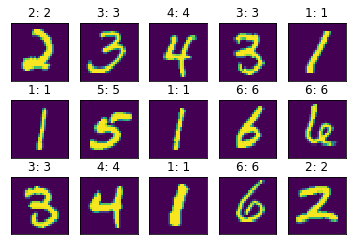

In [4]:
images, labels = next(m.get_training_batch(15,6))

plt.figure(figsize=(20,10))
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(str(labels[i]) + ": " + str(labels[i]))

### Helper Functions

In [17]:
def printAll(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
        print(v.name)
def getNames(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v.name)
    return lst_vars
def getTensors(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
    return lst_vars
def getUnititialized(allVars):
    uninitialized_vars = []
    for var in allVars:
        try:
            session.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)
    return uninitialized_vars
def getSubSet(toFreeze,All):
    for var in toFreeze:
        All.remove(var)
    return All
def OwnAccuracyCalculator(out,target):
    numRight = 0
    for i,e in enumerate(out):
        label = np.argmax(e)
        if label==target[i]:
            #print(label,target[i])
            numRight = numRight+1
    return numRight/out.shape[0]
def smoothListGaussian(list,strippedXs=False,degree=5):  
    #Code from https://www.swharden.com/wp/2008-11-17-linear-data-smoothing-in-python/
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed
def perfQuantifier(accs,esteps,smooth=True):
    if smooth:
        smoothacc = smoothListGaussian(accs,degree=20)
    else:
        smoothacc = accs
    numEpochs = esteps.shape[0]
    plateauStart = np.zeros((esteps.shape[0]-1))
    pleateau = np.zeros((esteps.shape[0]-1))
    mins = np.zeros((esteps.shape[0]-1))
    for i in range(numEpochs-1):
        part = smoothacc[esteps[i]:esteps[i+1]]
        tenpermax = max(part)-0.02#plateau starts when max-2% is reached
        #max(part)-(max(part)-min(part))/4#get threshold of 10% below maximum
        pleateau[i] = tenpermax
        plateauStart[i] = np.where(part>tenpermax)[0][0]
        mins[i] = np.min(accs[esteps[i]:esteps[i+1]])
    return plateauStart,pleateau,mins
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm
def OwnAccuracyCalculator(out,target,maxOld):
    numRight = 0
    RightNew = 0
    RightOld = 0
    WrongNew = 0
    WrongOld = 0
    for i,e in enumerate(out):
        label = np.argmax(e)       
        if target[i]<maxOld:         
            if label==target[i]:
                numRight = numRight+1
                RightOld = RightOld+1
            else:
                WrongOld = WrongOld+1
        else:
            if label==target[i]:
                numRight = numRight+1
                RightNew = RightNew+1
            else:
                WrongNew = WrongNew+1            
    AccAll = numRight/out.shape[0]
    AccOld = RightOld/(RightOld+WrongOld)
    AccNew = RightNew/(RightNew+WrongNew)
    return AccAll,AccOld,AccNew
#Plotting -------------------------------------------------------------------------------------------------------------
def plotPerformance(training_accuracies,validation_accuracies,steps,title):
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(3,2,hspace=0.4, wspace=0.4)
    fig.add_subplot(grid[:2,:])
    plt.plot(training_accuracies)
    plt.plot(np.append(validation_accuracies,validation_accuracies[-1]), linewidth=5)
    plt.plot(np.full(steps[-1],0.5), linewidth=5, color = 'black')
    plt.xlabel("Training Step", fontsize=18)
    plt.ylabel("Accuracy in %", fontsize=18)
    plt.title(title, fontsize=18)
    plt.xlim(0,steps[-1]-100)
    plt.legend(['training','validation','baseline'],fontsize=20,loc=3)
    start,v,mini = perfQuantifier(training_accuracies,steps)
    for s in steps:
        plt.axvline(x=s,color='r')
    for i in range(steps.shape[0]-1):
        plt.plot(np.linspace(steps[i],steps[i+1],steps[i+1]-steps[i]),np.full(steps[i+1]-steps[i],v[i]), linewidth=2, color = 'green')
        plt.axvline(x=steps[i]+start[i],color='green')
    plt.scatter(steps[:-1],mini,color='r')

    fig.add_subplot(grid[2,0])
    plt.bar(np.linspace(0,start.shape[0]-1
                        ,start.shape[0]),start)
    plt.title("Steps until Convergance in Reached (Max-2%)", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Number of Steps", fontsize=18)
    plt.xticks(np.linspace(0,start.shape[0]-1,start.shape[0]), np.linspace(0,start.shape[0]-1,start.shape[0])) 
    fig.add_subplot(grid[2,1])
    plt.bar(np.linspace(0,mini.shape[0]-1,mini.shape[0]),mini)
    plt.ylim(0,1)
    plt.title("Minimum Performance in this Training Cycle", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Performance in %", fontsize=18)
    plt.xticks(np.linspace(0,mini.shape[0]-1,mini.shape[0]), np.linspace(0,mini.shape[0]-1,mini.shape[0]))

def createNodeImg(NIn,NOut):
    AllOut = []
    for i in range(NOut):
        node = np.full(NIn,i)
        AllOut = np.append(AllOut,node)
    return AllOut
def plotWeights(weights,NIn,NOut):
    nodeRef = createNodeImg(NIn,NOut)
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(weights.reshape((NIn*NOut)//(NOut*8),NOut*8),vmin=-0.05,vmax=0.05)
    ax.set_title("Weights for "+str(NOut)+" Output Nodes")
    plt.colorbar()
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(nodeRef.reshape((NIn*NOut)//(NOut*8),NOut*8))
    ax2.set_title("Reference for Nodes")
    plt.show()
def plotOutDist(vlabels,out):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(vlabels,bins=out.shape[1])
    plt.title("Label Distribution")
    plt.subplot(1,2,2)
    plt.hist(np.argmax(out,axis=1),bins=out.shape[1])
    plt.title("Output Distribution")
def plotViolinWeights(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    fig = plt.figure(figsize=(15,5))
    sns.violinplot(x="groups", y="vals", data=wdf)
    plt.xlabel("Inputs to Class Node X",fontsize=18)
    plt.ylabel("Weights",fontsize=18)
    plt.title(title,fontsize=18)
    plt.show()
def plotViolinWeightsAx(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    ax = sns.violinplot(x="groups", y="vals", data=wdf)
    ax.set_xlabel("Inputs to Class Node X",fontsize=18)
    ax.set_ylabel("Weights",fontsize=18)
    ax.set_title(title,fontsize=18)
    return ax

## Network Graph

In [7]:
tf.reset_default_graph()
numOutP=6 #Number of output nodes at the beginning of training
x = tf.placeholder(tf.float32, shape = [None, 28, 28,1])
desired = tf.placeholder(tf.int64, shape = [None])

normx = tf.layers.batch_normalization(x)

with tf.variable_scope("model",reuse=tf.AUTO_REUSE):
    
    kernels_1 = tf.get_variable("kernels_1",shape=[5, 5, 1,16],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_1 = tf.nn.conv2d(normx, kernels_1, strides = [1, 1, 1,1], padding = "SAME", name="convolution_1")

    biases_1 = tf.get_variable("biases_1",[16],initializer=tf.constant_initializer(0.0))
    feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1, name="feature_maps_1")
    print(feature_maps_1.shape)

    pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_1")
    print(pool_1.shape)

    kernels_2 = tf.get_variable("kernels_2",[3, 3, 16, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_2 = tf.nn.conv2d(tf.layers.batch_normalization(pool_1), kernels_2, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_2")

    biases_2 = tf.get_variable("biases_2",[32],initializer=tf.constant_initializer(0.0))
    feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2, name="feature_maps_2")
    print(feature_maps_2.shape)

    pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_2")
    print("pool2: "+str(pool_2.shape))

    flattened = tf.reshape(tf.layers.batch_normalization(pool_2), [-1, 7 * 7 * 32], name="flattened")
    print(flattened.shape)
    
    startVars2 = getTensors(tf.global_variables())
    
    weights_3 = tf.get_variable("weights_3",[1568, 512],initializer=tf.truncated_normal_initializer(stddev = 1568**(-1/2)))
    biases_3 = tf.get_variable("biases_3",[512],initializer=tf.constant_initializer(0.0))
    hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3, name="hidden_layer")
    print(hidden_layer)
#startVars2 = getTensors(tf.global_variables()) # uncomment to only retrain last layer
startVars = getTensors(tf.global_variables())
def newLast(hiddenIn,numOut):
    with tf.variable_scope("LastLayer",reuse=False):
        #weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.truncated_normal_initializer(stddev = 512**(-1/2)))
        weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.constant_initializer(0.01))
        print("w4: "+str(weights_4))
        biases_4 = tf.get_variable('biases_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits,weights_4

def newLastInit(hiddenIn,numOut,init):
    with tf.variable_scope("LastLayerInit",reuse=False):
        weights_4 = tf.get_variable('weightsI_4'+str(numOut),[512,numOut],initializer=init)
        biases_4 = tf.get_variable('biasesI_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits,weights_4
    
def evaluate(outLogs,desired):    
    with tf.variable_scope("eval",reuse=tf.AUTO_REUSE):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = outLogs)
        accuracy = tf.equal(tf.argmax(tf.nn.softmax(outLogs), 1), desired)
        
    return accuracy,cross_entropy

with tf.variable_scope(tf.get_variable_scope()):
    outLog,w4 = newLast(hidden_layer,numOutP)
    print("out: "+str(outLog.shape))
    acc,CE = evaluate(outLog,desired)

accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
cross_entropy = tf.reduce_mean(CE)

learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')
#optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
training_step = optimizer.minimize(cross_entropy)
gradient = tf.gradients(cross_entropy, w4)[0]
print(gradient)

#startVars = getTensors(tf.global_variables())
#printAll(tf.global_variables())
DontFreezeList = getSubSet(startVars2,startVars)
#print(DontFreezeList)
#print(startVars2)

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
pool2: (?, 7, 7, 32)
(?, 1568)
Tensor("model/hidden_layer:0", shape=(?, 512), dtype=float32)
w4: <tf.Variable 'LastLayer/weights_46:0' shape=(512, 6) dtype=float32_ref>
out: (?, 6)
Tensor("gradients_1/LastLayer/MatMul_grad/MatMul_1:0", shape=(512, 6), dtype=float32)


### Growing Experiments

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


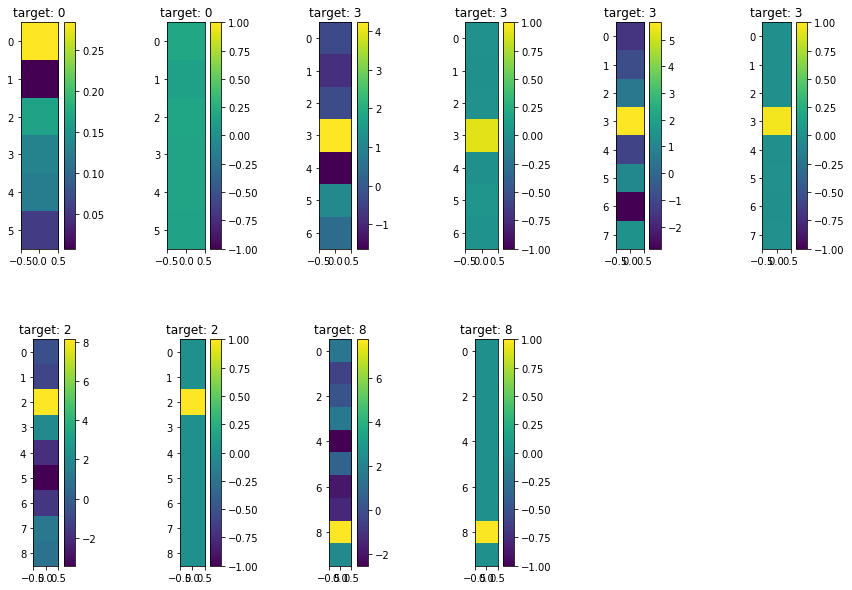

In [8]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
epochs = 1
newClasses = 5#Number of iterations through the dataset -> usually each time a new class is added
numC=6 # number of classes in the dataset

mini_batch_size = 200
plot_step_size = 50
training_steps = m.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs * newClasses)
validation_cross_entropies = np.zeros(training_steps * epochs * newClasses)

training_accuracies = np.zeros(training_steps * epochs * newClasses)
training_accuracies_old = np.zeros(training_steps * epochs * newClasses)
training_accuracies_new = np.zeros(training_steps * epochs * newClasses)
validation_accuracies = np.zeros(training_steps * epochs * newClasses)

ESteps = [0]
#weightName = 'LastLayer/weights_46/op_0:0'
weightName = 'LastLayer/weights_46:0'
outName = 'LastLayer/add:0'
n=1
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    for nC in range(newClasses):             
        last_step = False
        if nC>0:
            DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
            #----------Try different initializer for the last layer--------------
            #initializer = tf.truncated_normal_initializer(stddev = 512**(-1/2))
            initializer = tf.constant_initializer(np.append(weights,np.random.choice(weights.flatten(),(512,1)),axis=1))
            #initializer = tf.constant_initializer(np.append(weights,np.full((512,1),0),axis=1))
            #initializer = tf.constant_initializer(np.random.choice(weights.flatten(),512*numC))
            #initializer = tf.constant_initializer(0.0)
            with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                outLog,Wname = newLastInit(hidden_layer,numOutP,initializer)
                acc,CE = evaluate(outLog,desired)
                accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                cross_entropy = tf.reduce_mean(CE)
                           
                learning_rate = 1e-4
                #optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')#use standard gradient descent
                optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

            weightName = Wname
            gradient = tf.gradients(cross_entropy, weightName)[0]
            newVars = getUnititialized(tf.all_variables())
            DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
            #print(DontFreezeList)
            #training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)#only retrain part of the network
            training_step = optimizer.minimize(cross_entropy)
            uninitialized_vars = getUnititialized(tf.all_variables())
            init_new_vars_op = tf.initialize_variables(uninitialized_vars)
            session.run(init_new_vars_op)
        else:
            newVars = []
        s = 0
        for epoch in range(epochs):
            for images, labels in m.get_training_batch(mini_batch_size,numC-1):            
                if s == 10:
                    training_cross_entropies[step], training_accuracies[step],FirstOut,Firstweights,Firstgrad = session.run(
                    [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: np.reshape(images,(mini_batch_size,28,28,1)), desired: labels}
                )
                    FirstL = labels
                s = s+1
                training_cross_entropies[step], training_accuracies[step], _,trainOut = session.run(
                    [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: np.reshape(images,(mini_batch_size,28,28,1)), desired: labels}
                )
                Aall,old,new = OwnAccuracyCalculator(trainOut,labels,numC-2)
                training_accuracies_old[step] = old               
                training_accuracies_new[step] = new
                                
                
                if step == (training_steps * epochs)-1:
                    last_step = True

                if step % plot_step_size == 0 or last_step:
                    images, vlabels = next(m.get_validation_batch(0,numC-1))
                    
                    validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                        [cross_entropy, accuracy,outLog,weightName,gradient],
                        feed_dict = {x: np.reshape(images,(images.shape[0],28,28,1)), desired: vlabels}
                    )
                    
                    if step != 0:
                        on = step - plot_step_size if not last_step else step - plot_step_size + 1
                        off = on + plot_step_size
                        validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                        validation_accuracies[on:off] = [validation_accuracy] * plot_step_size

                    #print("Training: " , training_accuracies[step] , "validation: " , validation_accuracy, "numClasses: ", numC, " outlayersize: ",str(numOutP))
                step += 1
        numC = numC+1 #increase number of classes in the dataset
        numOutP = numOutP +1 #increase number of output neurons
        #print(weights)
        #print("old: "+str(weights))
        #print(weights.shape)
        #----Plot distribution of weights or gradients over the layer and epochs----
        #ax = fig.add_subplot(7, 1, n)
        #plotViolinWeightsAx(weights,"End Weights for each Output Node - Old Weight Init, Zero Start")
        #plotWeights(weights,512,weights.shape[1])
        #----Plot Output activations for each epoch-------
        ax = fig.add_subplot(2, 6, n)
        plt.imshow(FirstOut[1].reshape((numC-1,1)))
        ax.set_title("target: "+str(FirstL[1]))
        plt.colorbar()
        ax = fig.add_subplot(2, 6, n+1)
        plt.imshow(softmax(FirstOut[1]).reshape((numC-1,1)),vmin=-1,vmax=1)
        ax.set_title("target: "+str(FirstL[1]))
        plt.colorbar()
        n = n+2
        ESteps = np.append(ESteps,step)
        #n=n+1

### Performance Comparison for Old and New Classes

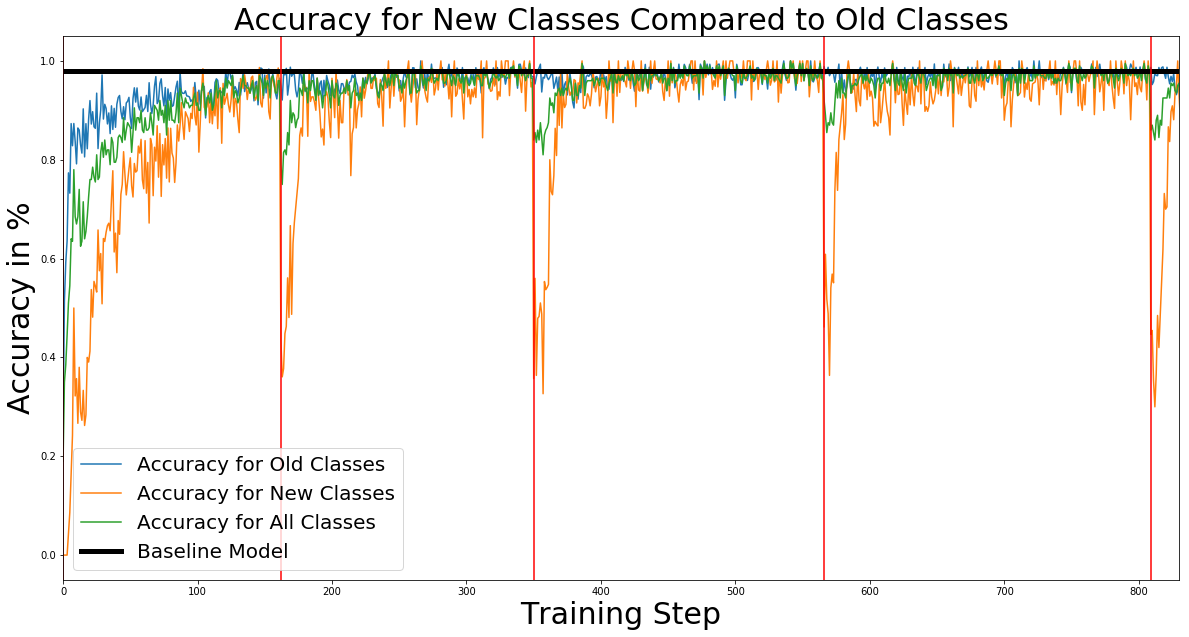

In [23]:
plt.figure(figsize=(20,10))
plt.plot((training_accuracies_old))
plt.plot((training_accuracies_new))
plt.plot((training_accuracies))
plt.plot(np.full(850,0.98), linewidth=5, color = 'black')
plt.xlabel("Training Step", fontsize=30)
plt.ylabel("Accuracy in %", fontsize=30)
plt.title("Accuracy for New Classes Compared to Old Classes", fontsize=30)
plt.xlim(0,830)
plt.legend(['Accuracy for Old Classes','Accuracy for New Classes','Accuracy for All Classes','Baseline Model'],fontsize=20,loc=3)
for e in ESteps:
    plt.axvline(x=e,color='r')
#plt.show()
plt.savefig('Results/MNIST_AccOldNew.png')

### Overall Performance

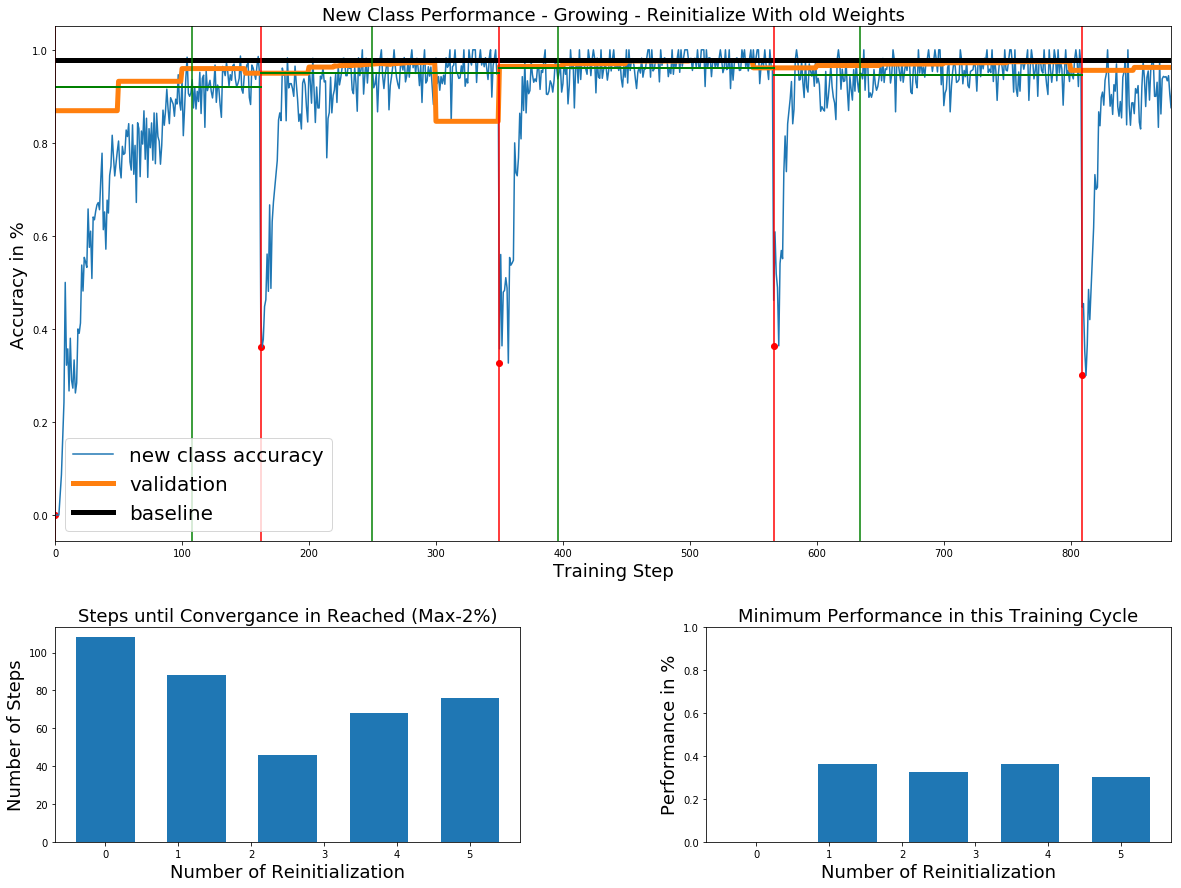

In [19]:
plotPerformance(training_accuracies_new,validation_accuracies,ESteps,"New Class Performance - Growing - Reinitialize With old Weights")
plt.savefig('Results/MNIST_newClassPerf.png')

### Weight Initialization Comparison

In [14]:
ta0 = training_accuracies
va0 = validation_accuracies

In [30]:
taW001 = training_accuracies
vaW001 = validation_accuracies

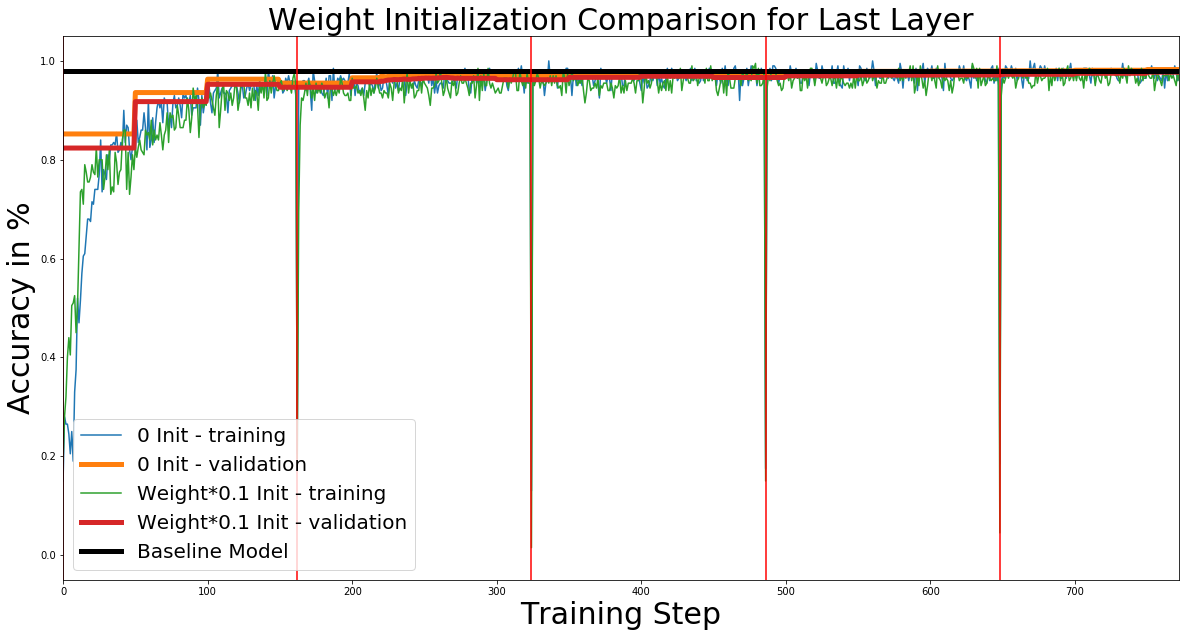

In [15]:
plt.figure(figsize=(20,10))
plt.plot(ta0)
plt.plot(va0, linewidth=5)
plt.plot(taW2)
plt.plot(vaW2, linewidth=5)
plt.plot(np.full(ESteps[-1]-200,0.979), linewidth=5, color = 'black')
plt.xlabel("Training Step", fontsize=30)
plt.ylabel("Accuracy in %", fontsize=30)
plt.title("Weight Initialization Comparison for Last Layer", fontsize=30)
plt.xlim(0,ESteps[-1]-200)
plt.legend(['0 Init - training','0 Init - validation','Weight*0.1 Init - training','Weight*0.1 Init - validation','Baseline Model'],fontsize=20,loc=3)
for s in ESteps:
    plt.axvline(x=s,color='r')
plt.show()

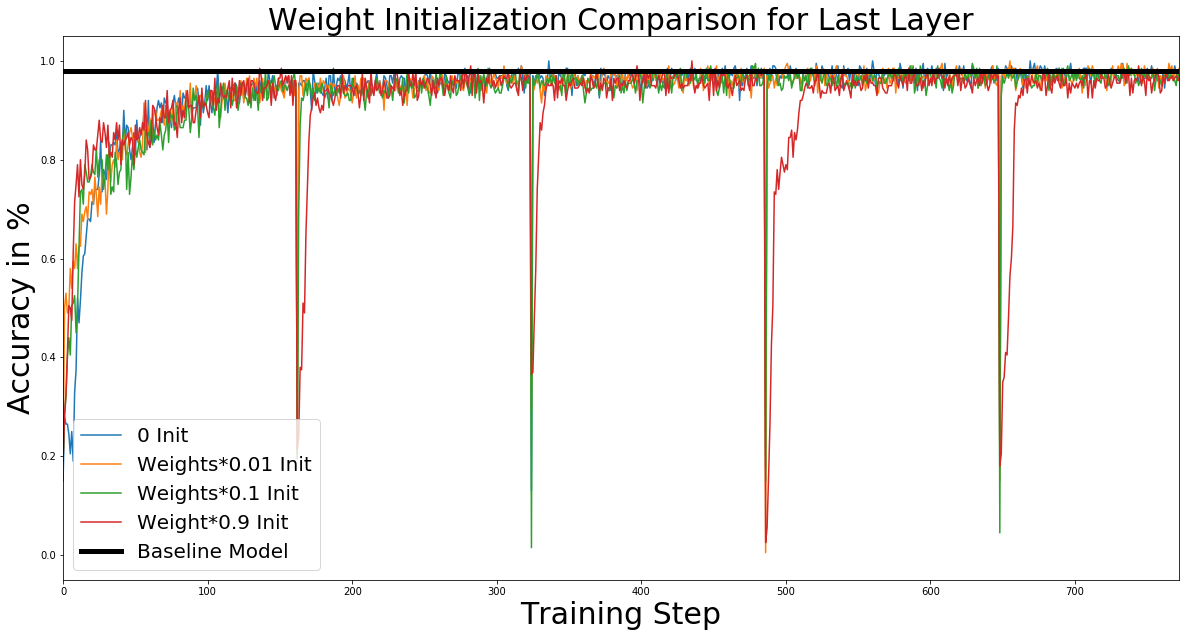

In [34]:
plt.figure(figsize=(20,10))
plt.plot(ta0)
plt.plot(taW001)
plt.plot(taW2)
plt.plot(taW09)
plt.plot(np.full(ESteps[-1]-200,0.979), linewidth=5, color = 'black')
plt.xlabel("Training Step", fontsize=30)
plt.ylabel("Accuracy in %", fontsize=30)
plt.title("Weight Initialization Comparison for Last Layer", fontsize=30)
plt.xlim(0,ESteps[-1]-200)
plt.legend(['0 Init','Weights*0.01 Init','Weights*0.1 Init','Weight*0.9 Init','Baseline Model'],fontsize=20,loc=3)
#for s in ESteps:
#    plt.axvline(x=s,color='r')
plt.show()

## Further Tests on Reinitialization

In [60]:
tf.reset_default_graph()
numOutP=10
#numOutP = tf.placeholder(tf.int64)
x = tf.placeholder(tf.float32, shape = [None, 28, 28,1])
desired = tf.placeholder(tf.int64, shape = [None])

normx = tf.layers.batch_normalization(x)

with tf.variable_scope("model",reuse=tf.AUTO_REUSE):
    
    kernels_1 = tf.get_variable("kernels_1",shape=[5, 5, 1,16],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_1 = tf.nn.conv2d(normx, kernels_1, strides = [1, 1, 1,1], padding = "SAME", name="convolution_1")

    biases_1 = tf.get_variable("biases_1",[16],initializer=tf.constant_initializer(0.0))
    feature_maps_1 = tf.nn.tanh(convolution_1 + biases_1, name="feature_maps_1")
    print(feature_maps_1.shape)

    pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_1")
    print(pool_1.shape)

    kernels_2 = tf.get_variable("kernels_2",[3, 3, 16, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_2 = tf.nn.conv2d(tf.layers.batch_normalization(pool_1), kernels_2, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_2")

    biases_2 = tf.get_variable("biases_2",[32],initializer=tf.constant_initializer(0.0))
    feature_maps_2 = tf.nn.tanh(convolution_2 + biases_2, name="feature_maps_2")
    print(feature_maps_2.shape)

    pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_2")
    print("pool2: "+str(pool_2.shape))

    flattened = tf.reshape(tf.layers.batch_normalization(pool_2), [-1, 7 * 7 * 32], name="flattened")
    print(flattened.shape)
    
    startVars2 = getTensors(tf.global_variables())
    
    weights_3 = tf.get_variable("weights_3",[1568, 512],initializer=tf.truncated_normal_initializer(stddev = 1568**(-1/2)))
    biases_3 = tf.get_variable("biases_3",[512],initializer=tf.constant_initializer(0.0))
    hidden_layer = tf.nn.tanh(tf.matmul(flattened, weights_3) + biases_3, name="hidden_layer")
    print(hidden_layer)
#startVars2 = getTensors(tf.global_variables()) # uncomment to only retrain last layer
startVars = getTensors(tf.global_variables())
def newLast(hiddenIn,numOut):
    with tf.variable_scope("LastLayer",reuse=False):
        #weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.truncated_normal_initializer(stddev = 512**(-1/2)))
        weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.constant_initializer(0.01))
        
        biases_4 = tf.get_variable('biases_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits

def newLastInit(hiddenIn,num,init):
    with tf.variable_scope("LastLayerInit",reuse=False):
        weights_4 = tf.get_variable('weightsI_4'+str(num),[512,numOutP],initializer=init)
        biases_4 = tf.get_variable('biasesI_4'+str(num),[numOutP],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits,weights_4
    
def evaluate(outLogs,desired):    
    with tf.variable_scope("eval",reuse=tf.AUTO_REUSE):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = outLogs)
        accuracy = tf.equal(tf.argmax(tf.nn.softmax(outLogs), 1), desired)
        
    return accuracy,cross_entropy

with tf.variable_scope(tf.get_variable_scope()):
    outLog = newLast(hidden_layer,numOutP)
    acc,CE = evaluate(outLog,desired)

accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
cross_entropy = tf.reduce_mean(CE)

learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')
#optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
training_step = optimizer.minimize(cross_entropy)

#startVars = getTensors(tf.global_variables())
printAll(tf.global_variables())
DontFreezeList = getSubSet(startVars2,startVars)
#print(DontFreezeList)
#print(startVars2)

(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 14, 14, 32)
pool2: (?, 7, 7, 32)
(?, 1568)
Tensor("model/hidden_layer:0", shape=(?, 512), dtype=float32)
batch_normalization/gamma:0
batch_normalization/beta:0
batch_normalization/moving_mean:0
batch_normalization/moving_variance:0
model/kernels_1:0
model/biases_1:0
model/kernels_2:0
model/batch_normalization/gamma:0
model/batch_normalization/beta:0
model/batch_normalization/moving_mean:0
model/batch_normalization/moving_variance:0
model/biases_2:0
model/batch_normalization_1/gamma:0
model/batch_normalization_1/beta:0
model/batch_normalization_1/moving_mean:0
model/batch_normalization_1/moving_variance:0
model/weights_3:0
model/biases_3:0
LastLayer/weights_410:0
LastLayer/biases_410:0
LastLayer/batch_normalization/gamma:0
LastLayer/batch_normalization/beta:0
LastLayer/batch_normalization/moving_mean:0
LastLayer/batch_normalization/moving_variance:0
beta1_power:0
beta2_power:0
batch_normalization/gamma/op_0:0
batch_normalization/gamma/op_0_1:0
batch_n

### Reinitialization Without Growing

Training:  0.12999999523162842 validation:  0.28433332 numOut:  9 0
Training:  0.6899999976158142 validation:  0.72083336 numOut:  9 0
Training:  0.8650000095367432 validation:  0.83916664 numOut:  9 0
Training:  0.8849999904632568 validation:  0.8973333 numOut:  9 0
Training:  0.9150000214576721 validation:  0.9216667 numOut:  9 0
Training:  0.9649999737739563 validation:  0.9368333 numOut:  9 0
Training:  0.925000011920929 validation:  0.9425 numOut:  9 0
Training:  0.9350000023841858 validation:  0.9468333 numOut:  9 1
Training:  0.9549999833106995 validation:  0.9533333 numOut:  9 1
Training:  0.9300000071525574 validation:  0.9576667 numOut:  9 1
Training:  0.9599999785423279 validation:  0.9605 numOut:  9 1
Training:  0.9449999928474426 validation:  0.96433336 numOut:  9 1
Training:  0.9700000286102295 validation:  0.9655 numOut:  9 2
Training:  0.925000011920929 validation:  0.96683335 numOut:  9 2
Training:  0.949999988079071 validation:  0.9688333 numOut:  9 2
Training:  0.964

<Figure size 1080x720 with 0 Axes>

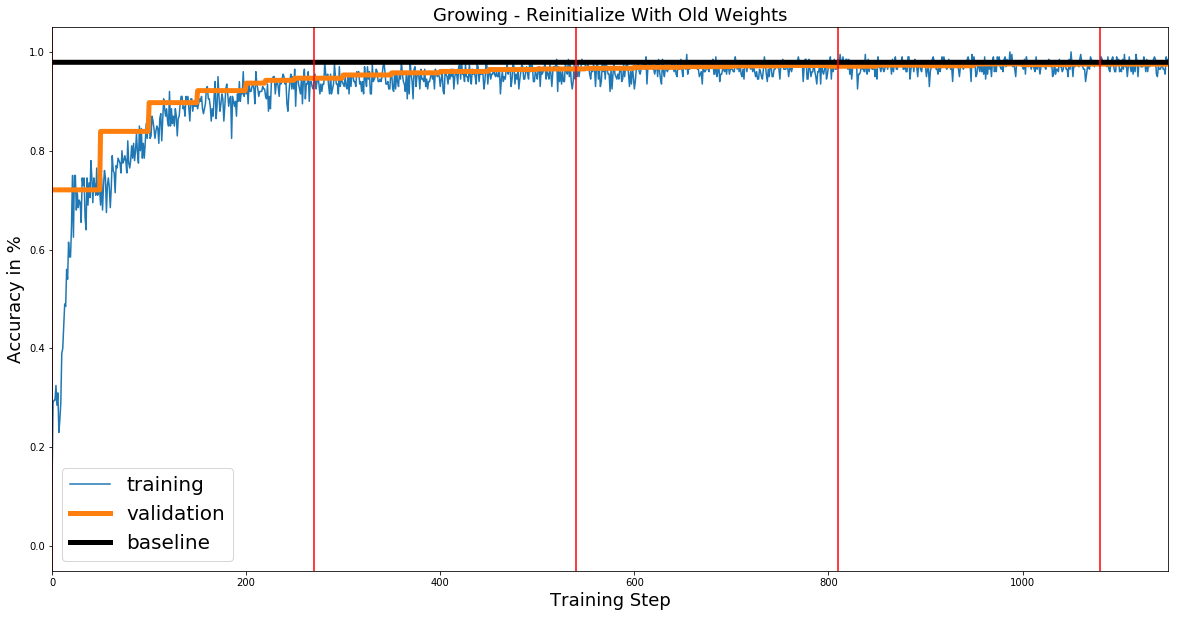

In [61]:
fig = plt.figure(figsize=(15,10))
epochs = 1
newClasses = 5
numC=10

mini_batch_size = 200
plot_step_size = 50
training_steps = m.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs * newClasses)
validation_cross_entropies = np.zeros(training_steps * epochs * newClasses)

training_accuracies = np.zeros(training_steps * epochs * newClasses)
validation_accuracies = np.zeros(training_steps * epochs * newClasses)

ESteps = [0]
#weightName = 'LastLayer/weights_46/op_0:0'
weightName = 'LastLayer/weights_410:0'
outName = 'LastLayer/add:0'
n=1
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    for nC in range(newClasses):             
        last_step = False
        if nC>0:
            DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
            #initializer = tf.truncated_normal_initializer(stddev = 512**(-1/2))
            #initializer = tf.constant_initializer(weights)
            initializer = tf.constant_initializer(np.append(weights,np.full(0,512)))
            #initializer = tf.constant_initializer(np.random.choice(weights.flatten(),512*numC))
            #initializer = tf.constant_initializer(0.0)
            with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                outLog,Wname = newLastInit(hidden_layer,nC+10,initializer)
                acc,CE = evaluate(outLog,desired)
                accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                cross_entropy = tf.reduce_mean(CE)
                           
                learning_rate = 1e-4
                #optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
                optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

            weightName = Wname
            newVars = getUnititialized(tf.all_variables())
            DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
            #print(DontFreezeList)
            training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)
            uninitialized_vars = getUnititialized(tf.all_variables())
            init_new_vars_op = tf.initialize_variables(uninitialized_vars)
            session.run(init_new_vars_op)
        else:
            newVars = []
        s = 0
        for epoch in range(epochs):
            for images, labels in m.get_training_batch(mini_batch_size,numC-1):            
                if s == 10:
                    training_cross_entropies[step], training_accuracies[step], _,FirstOut = session.run(
                    [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: np.reshape(images,(mini_batch_size,28,28,1)), desired: labels}
                )
                    FirstL = labels
                s = s+1
                training_cross_entropies[step], training_accuracies[step], _ = session.run(
                    [cross_entropy, accuracy, training_step],feed_dict ={x: np.reshape(images,(mini_batch_size,28,28,1)), desired: labels}
                )
                                
                
                if step == (training_steps * epochs)-1:
                    last_step = True

                if step % plot_step_size == 0 or last_step:
                    images, vlabels = next(m.get_validation_batch(0,numC-1))
                    
                    validation_cross_entropy, validation_accuracy,out,weights= session.run(
                        [cross_entropy, accuracy,outLog,weightName],
                        feed_dict = {x: np.reshape(images,(images.shape[0],28,28,1)), desired: vlabels}
                    )
                    
                    if step != 0:
                        on = step - plot_step_size if not last_step else step - plot_step_size + 1
                        off = on + plot_step_size
                        validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                        validation_accuracies[on:off] = [validation_accuracy] * plot_step_size

                    print("Training: " , training_accuracies[step] , "validation: " , validation_accuracy, "numOut: ", numC-1, str(nC))
                step += 1
        #print(weights)
        #print("old: "+str(weights))
        #print(weights.shape)
        #plotWeights(weights,512,weights.shape[1])
        ESteps = np.append(ESteps,step)
plotPerformance(training_accuracies,validation_accuracies,ESteps,"Growing - Reinitialize With Old Weights")
#plt.savefig('Results/WeightsRandomFill.png')

## Normal Training

<Figure size 1080x1800 with 0 Axes>

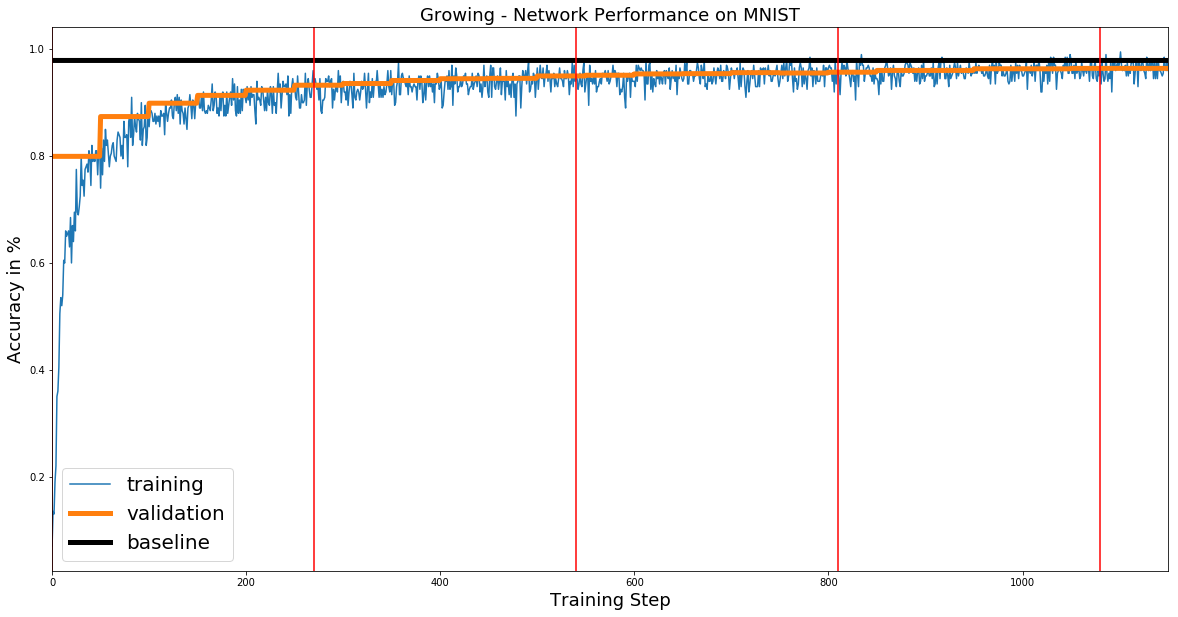

In [23]:
fig = plt.figure(figsize=(15,25))
epochs = 5

mini_batch_size = 200
plot_step_size = 50
training_steps = m.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs)
validation_cross_entropies = np.zeros(training_steps * epochs)

training_accuracies = np.zeros(training_steps * epochs)
validation_accuracies = np.zeros(training_steps * epochs)

ESteps = [0]
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0            
    last_step = False
    for epoch in range(epochs):
        for images, labels in m.get_training_batch(mini_batch_size,10):            
            imin = np.reshape(images,(mini_batch_size,28,28,1))
            training_cross_entropies[step], training_accuracies[step], _ = session.run(
                [cross_entropy, accuracy, training_step],feed_dict ={x: imin, desired: labels}
            )
            if step == (training_steps * epochs)-1:
                last_step = True

            if step % plot_step_size == 0 or last_step:
                images, labels = next(m.get_validation_batch(0,10))
                imin = np.reshape(images,(images.shape[0],28,28,1))
                validation_cross_entropy, validation_accuracy,out= session.run(
                    [cross_entropy, accuracy,outLog],
                    feed_dict = {x: imin, desired: labels}
                )

                if step != 0:
                    on = step - plot_step_size if not last_step else step - plot_step_size + 1
                    off = on + plot_step_size
                    validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                    validation_accuracies[on:off] = [validation_accuracy] * plot_step_size

                #print("Training: " , training_accuracies[step] , "validation: " , validation_accuracy)
            step += 1
        ESteps = np.append(ESteps,step)
plotPerformance(training_accuracies,validation_accuracies,ESteps,"Growing - Network Performance on MNIST")